# Machine Learning 


## General - Scikit-Learn Design
All objects within scikit-learn share a unifrom common basic API consisting of three complementary interfaces: 
+ <b>estimator</b> <i>interface for building and fitting models</i>
+ <b>predictor</b> <i>interface for making predictions</i>
+ <b>transformer</b> <i>interface vor converting data.</i>

### Estimators 
The estimator interface is at the core of the library. It defines instantiation mechanisms of objects and exposes a <em>fit()</em> method for learning a model from training data. Estimator initialization and actual learning are strictly separated, in a way that is similar to partial function application: an estimator is initialized from a set of named constant hyper-parameter values and can be considered as a function that maps these values to an actual learning algorithm. The constructor of an estimator does not see any actual data, nor does it perform any actual learning. All it does is attaching the given parameteres to the object. Default hyper-parameters values are also provided for all built-in estimators. These default values are set to be relevant in many common situation in order to make estimators as effective as possible out-of-box even for non-experts.
Actual learning is performed by the <em>fit()</em> method. Its task is to run a learning algorithm and to determine model-specific parameters from the training data and set these attributes on the estimator object. 

### Predictors
The predictor interface extends the notion of an estimator by adding a <em>predict()</em> method that takes an array $X\_test$ and produces predictions for $X\_test$, based on the  learned parameters of the estimator. Hence, in the case of supervised learning estimators, this method typically returns the predicted labels or values computed by the model. 

### Transformers
Since it is common to modify or filter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which defines a <em>transform()</em> method. It takes as input some new data, e.g., $X\_test$ and yields as output a transformed version of $X\_test$. Preprocessing, features selection, feature extraction and dimensionalty reduction algorithms are all provided as transformers within the library. 

## Train and Test Split

The train and test split involves separating a dataset into two parts:

* <b>Training Dataset.</b> The training dataset is used by the ML algorithm to train the model. 
* <b>Test Dataset.</b> The test dataset is held back and is used to evaluate the performance of the model.

The rows assigned to each dataset are randomly selected. This is an attempt to ensure that the training and evaluation of a model is objective. If multiple algorithms are compared or multiple configurations of the same algorithm are compared, the same train and test split of the dataset should be used. This is to ensure that the comparison of performance is consistent. We can achieve this by seeding the random number generator the same way before splitting the data, or by holding the same split of the dataset for use by multiple algorithms.

In [1]:
from random import seed
from sklearn.datasets import load_iris
import numpy as np
from numpy.random import choice
import pandas as pd
from math import floor

# Split a dataset into a train and test set
def train_test_split(dataset, split=0.60):
    '''
    Splitting dataset in train and test data.
        
    Parameters
    ----------
    dataset : the dataset to be splitted
    split : the ratio of data in the train data (default: 0.6)
    Returns
    -------
    train_data, test_data: datasets containing the train data, respectively, test data 
    '''
    n, p = dataset.shape
    n_train = floor(n*split)
    train_idx = choice(np.arange(n), replace=False, size=n_train)
    test_idx = np.setdiff1d(np.arange(n), train_idx)
    train_data = dataset.iloc[train_idx, :]
    test_data = dataset.iloc[test_idx, :]
    return train_data, test_data

In [2]:
# test train/test split
#example: iris data
#http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris
seed(42)
iris = load_iris()
X_data = iris.data
target_data = iris.target.reshape(-1,1)
iris_data = np.c_[X_data, target_data]
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
colnames = [iris.feature_names, 'species']
colnames = flatten(colnames)
iris_data = pd.DataFrame(iris_data)
iris_data.columns = colnames

iris_train, iris_test = train_test_split(dataset = iris_data)

print(iris_train.shape)
print(iris_test.shape)

print(iris_train.head(n=5))
print(iris_test.head(n=5))

(90, 5)
(60, 5)
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
143                6.8               3.2                5.9               2.3   
96                 5.7               2.9                4.2               1.3   
139                6.9               3.1                5.4               2.1   
21                 5.1               3.7                1.5               0.4   

     species  
0        0.0  
143      2.0  
96       1.0  
139      2.0  
21       0.0  
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
1                 4.9               3.0                1.4               0.2   
10                5.4               3.7                1.5               0.2   
11                4.8               3.4                1.6               0.2   
12                4.8               3.0                1.4               0.1   
13     

## K-fold Cross Validation Split

A limitation of using the train and test split method is that we get a noisy estimate of algorithm performance.

Therefore, the $\textbf{k-fold cross validation}$ method has been introduced. It is also called just $\textit{cross validation}$. Cross validation is a resampling method that provides a more accurate estimate of an algorithm performance.

It does this by first splitting the data into $k$ groups. The algorithm is then trained and evaluated $k$ times and the performance summarized by taking the mean performance score. Each group of data is called a fold, hence the name $k$-fold cross-validation.

It works by first training the algorithm on the $k-1$ groups of the data and evaluating it on the $k$-th hold-out group as the test set. This is repeated so that each of the $k$ groups is given an opportunity to be held out and used as the test set.

As such, the value of $k$ should be divisible by the number of rows in your training dataset, to ensure each of the $k$ groups has the same number of rows.

You should choose a value for $k$ that splits the data into groups with enough rows that each group is still representative of the original dataset. A good default to use is k=3 for a small dataset or k=10 for a larger dataset. A quick way to check if the fold sizes are representative is to calculate summary statistics such as mean and standard deviation and see how much the values differ from the same statistics on the whole dataset.

We can reuse what we learned in the previous section in creating a train and test split here in implementing $k$-fold cross validation.

Instead of two groups, we must return $k$-folds or $k$ groups of data.

In [3]:
##task 2 - implement k-fold cross-validation
from random import seed
from sklearn.datasets import load_iris
import numpy as np
from numpy.random import choice
import pandas as pd
from math import floor

# Split a dataset into k folds
def cross_validation_split(dataset, folds=3):
    '''
    Generating a cross validation split of a datasets. 
    The function splits the data into k-folds with k 
    being the number of folds.
        
    Parameters
    ----------
    dataset : dataset which is splitted
    folds: number of folds (default: 3)
    Returns
    -------
    dataset_split: a list containing the separated folds
    '''
    n, p = dataset.shape
    #create empty dictionary which stores all folds
    k_folds = {fold: None for fold in map('fold{}'.format, range(1, folds+1))} 
    #compute split ratio for each cross-validation fold by ((k-1)/k * n) / n
    split_ratio =  ((folds-1)/folds * n)/n
    #for each fold call train_test_split function
    for fold in k_folds:
        train_data, test_data = train_test_split(dataset = dataset, split = split_ratio)
        k_folds[fold] = {"train":train_data, "test":test_data}
    return k_folds

In [4]:
# test cross validation split
iris_folds = cross_validation_split(iris_data, folds=4)

print(iris_folds["fold1"]["train"].shape)
print(iris_folds["fold1"]["train"].head())
print(iris_folds["fold1"]["test"].shape)
print(iris_folds["fold1"]["test"].head())


print(iris_folds["fold2"]["train"].shape)
print(iris_folds["fold2"]["train"].head())
print(iris_folds["fold2"]["test"].shape)
print(iris_folds["fold2"]["test"].head())

(112, 5)
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
68                 6.2               2.2                4.5               1.5   
136                6.3               3.4                5.6               2.4   
122                7.7               2.8                6.7               2.0   
72                 6.3               2.5                4.9               1.5   
32                 5.2               4.1                1.5               0.1   

     species  
68       1.0  
136      2.0  
122      2.0  
72       1.0  
32       0.0  
(38, 5)
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
1                 4.9               3.0                1.4               0.2   
3                 4.6               3.1                1.5               0.2   
9                 4.9               3.1                1.5               0.1   
19                5.1               3.8                1.5               0.3   
26    

## Learning curves by the number of training examples
We now know how to use cross-validation which can be used to estimate of a model's generalization performance. Another way is to look at the <i>learning curves</i>. These are plots of the model's performance on the training set and the validation set <b>as a function of the training set size</b>. 

## TASKS
* Overall Goal: train a model (scikit-learn model, e.g., LinearRegression) several times on different sized subsets of one training set. Plot the performance on the training set and the validation as a function of the training set size.

Steps to go:

* split the dataset into a training and test dataset
* iterate the size of the training data
* train the model being attached as a parameter and evaluate the training error, respectively, the error on the test data
* plot the training error and test error (y-axis) by the size of the training set (x-axis) which has been used for training

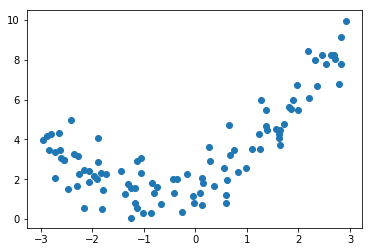

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

# number of instances
m = 100
# dataset
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
# plot
plt.figure()
plt.scatter(np.sort(X), np.sort(y))

In [6]:
def plot_learning_curve(model,X,y, test_sizes = np.linspace(start=0.1, stop=0.6, num=50)):
    '''
    Generating a plot of a learning curve
        
    Parameters
    ----------
    model : model which is used for training the dataset
    X: dataset
    y: labels     
    '''
    no_iter = len(test_sizes)
    performance_measure =  [None] * no_iter
    i = 0
    for size in test_sizes:
        # Create machine learning model
        ml_model = model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= size, random_state=42)

        # Train the model using the training sets
        ml_model.fit(X_train, y_train)
        
        # Make predictions using the testing set
        y_pred = ml_model.predict(X_test)
        performance_measure[i] = mean_squared_error(y_test, y_pred)
        i += 1
    plt.scatter(x=test_sizes, y=performance_measure, linestyle='-', marker='o')
    plt.plot(test_sizes, performance_measure, color='blue', linewidth=1)
    plt.show()
    

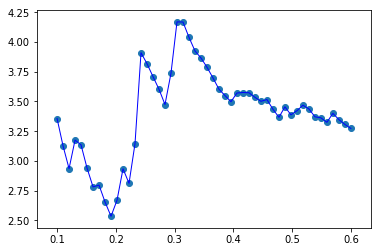

In [7]:
# Example for calling the function
from sklearn.linear_model import LinearRegression
ml_model = LinearRegression()
plot_learning_curve(ml_model, X,y)

# Regularized linear models
in the lecture as well as in the introduction to tensorflow, we have already seen a linear regression model. Here a short recap: the prediction of a linear regression model can be formulated as:

$$
\hat{y} = h_\theta (\mathbf{x}) = \theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n = \theta^{T} \cdot \mathbf{x}
$$

, where $\hat{y}$ is the predicted value, $n$ the number of features and $\theta_j$ is the $j$-th model parameter.
To measure how well (or poorly) the model fits the training data we can use the Mean Square Error. Hence, our goal is to find a value of $\theta$ that minimizes the MSE.

$$
MSE (\mathbf{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T} \cdot x^i - y^i)^2
$$

One way to reduce overfitting is to regularize the model, i.e., to constrain it in its degrees of freedom. For a linear model, regularization means constraining the weights of the model. In this part of this tutorial, we will take a look at two common regularizations, called Ridge Regression and Lasso Regression.

Let's say the following dataset is given:

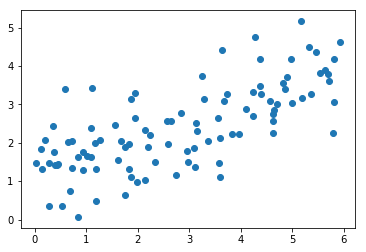

In [8]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1)
y = 1 + 0.5 * X + .85 * np.random.randn(m, 1)
plt.figure()
plt.scatter(X,y)

from sklearn.linear_model import Ridge

### TASKS
In the following the method plot_model shall be implemented. A model and various alphas for the regularizations are in the parameter list. Therefore, we iterate the alphas and apply them to the model. We use the sklearn framework described in the very beginning of this tutorial. We train the model (method to train a model in sklearn is the <em>fit()</em> method) on the dataset given above and calculate the predicted values (<em>predict()</em>). Lastly, we plot the models to see how well (or poor) the model fits the data.

In [9]:
def plot_model(model_class, alphas, **model_kargs):
    
    #Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state=42)
    performance_measure = [None] * len(alphas)
    i = 0
    for alpha in alphas:
        #define learner
        ridge_regression = Ridge(alpha=alpha)
        #fit learner
        ridge_regression.fit(X_train, y_train)
        #predict test data
        y_pred = ridge_regression.predict(X_test)
        performance_measure[i] = mean_squared_error(y_test, y_pred)
        print("Ridge Regression, alpha: ", alpha)
        print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
        i += 1
        # Plot outputs
        plt.scatter(X_test, y_test,  color='black')
        plt.plot(X_test, y_pred, color='blue', linewidth=1)
        plt.show()

### Ridge Regression
Ridge regression - also called Tikhonov regularization - performs a L2 regularization. That is to say it adds a penalty equivalent to the <b>square of the magnitude</b> of coefficients, i.e. the regularization term equal to $\alpha \sum_{i=1}^{n} \theta_i^2$ is added to the cost function. 

$$
J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n} \theta_i^2
$$

This forces the learning algorithm to keep the weights as small as possible. The hyperparameter $\alpha$ controls how much the model is regularized. For $\alpha=0$ Ridge Regression becomes Linear Regression. For a very large value for $\alpha$, all weights end up very close to zero and the result is a flat line going through the data's mean. 

Ridge Regression, alpha:  0
Mean Squared Error:  0.5006061883685795


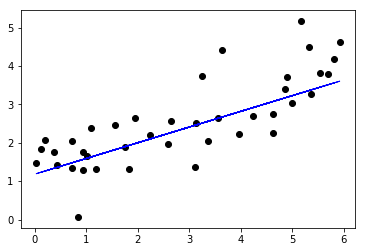

Ridge Regression, alpha:  10
Mean Squared Error:  0.5118920112361351


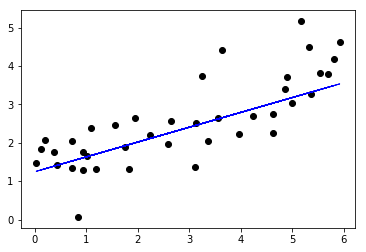

Ridge Regression, alpha:  100
Mean Squared Error:  0.6460283478380153


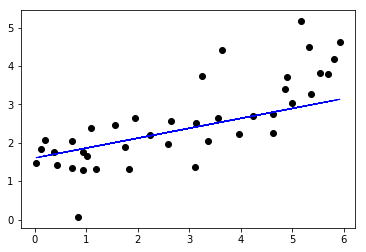

In [10]:
from sklearn.linear_model import Ridge
plot_model(Ridge, alphas=(0, 10, 100))

### LASSO Regression 
Least Absolute Shrinkage and Selection Operator - for short LASSO - regression performs a L1 regularization. That is to say it adds a penalty equivalent to the <b>abolute value of the magnitude</b> of coefficients, i.e., the penalty term $\alpha \sum_{i=1}^n |\theta_i|$ is added to the cost function.

$$
J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n |\theta_i|
$$

One major characteristic of Lasso Regression is that it tends to eliminiate weights of the least important features and sets them to zero.

Ridge Regression, alpha:  0
Mean Squared Error:  0.5006061883685795


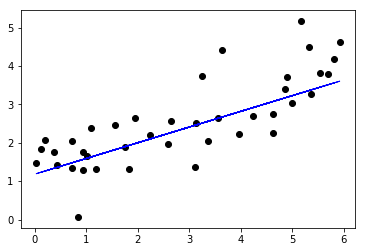

Ridge Regression, alpha:  0.1
Mean Squared Error:  0.500706239159903


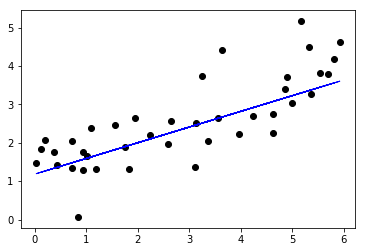

Ridge Regression, alpha:  1
Mean Squared Error:  0.5016198647977158


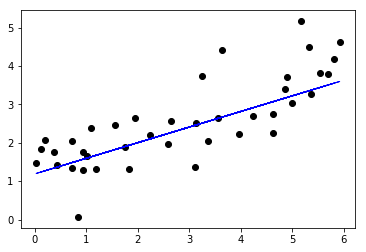

In [11]:
from sklearn.linear_model import Lasso
plot_model(Lasso, alphas=(0, 0.1, 1))

Feel free to play around with other models and their regularizations.

# End of this tutorial